In [2]:
from lsst.sims.maf.metrics.baseMetric import BaseMetric
import lsst.sims.maf.utils as mafUtils
import lsst.sims.utils as utils
from scipy import interpolate

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp

import lsst.sims.maf.db as db
import lsst.sims.maf.utils as utils
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.stackers as stackers
import lsst.sims.maf.metricBundles as metricBundles

from lsst.sims.utils import _galacticFromEquatorial
#from lsst.sims.photUtils import Dust_values

import scipy.integrate as integrate

In [3]:
# Grab this until datalab can update sims_photUtils
from lsst.sims.photUtils import Sed, BandpassDict
class Dust_values(object):
    """Calculate extinction values

    Parameters
    ----------
    R_v : float (3.1)
        Extinction law parameter (3.1).
    bandpassDict : dict (None)
        A dict with keys of filtername and values of lsst.sims.photUtils.Bandpass objects. Default
        of None will load the standard ugrizy bandpasses.
    ref_ev : float (1.)
        The reference E(B-V) value to use. Things in MAF assume 1.
    """
    def __init__(self, R_v=3.1, bandpassDict=None, ref_ebv=1.):
        # Calculate dust extinction values
        self.Ax1 = {}
        if bandpassDict is None:
            bandpassDict = BandpassDict.loadTotalBandpassesFromFiles(['u', 'g', 'r', 'i', 'z', 'y'])

        for filtername in bandpassDict:
            wavelen_min = bandpassDict[filtername].wavelen.min()
            wavelen_max = bandpassDict[filtername].wavelen.max()
            testsed = Sed()
            testsed.setFlatSED(wavelen_min=wavelen_min, wavelen_max=wavelen_max, wavelen_step=1.0)
            self.ref_ebv = ref_ebv
            # Calculate non-dust-extincted magnitude
            flatmag = testsed.calcMag(bandpassDict[filtername])
            # Add dust
            a, b = testsed.setupCCM_ab()
            testsed.addDust(a, b, ebv=self.ref_ebv, R_v=R_v)
            # Calculate difference due to dust when EBV=1.0 (m_dust = m_nodust - Ax, Ax > 0)
            self.Ax1[filtername] = testsed.calcMag(bandpassDict[filtername]) - flatmag

In [6]:
class star_density(object):
    """integrate from zero to some max distance, then multiply by angular area
    
    Parameters
    ----------
    l : float
        Galactic longitude, radians
    b : float
        Galactic latitude, radians
    """
    def __init__(self, l,b):
        """Calculate the expected number of stars along a line of site"""
        self.r_thin = 2.6  # scale length of the thin disk, kpc
        self.D_gc = 8.178  # Distance to the galactic center, kpc
        self.h_thin = 0.300  # scale height of the thin disk, kpc
        
        self.l = l
        self.b = b
        
        self.A = 0.8e8/(4.*np.pi*self.h_thin*self.r_thin**2)
        
    def __call__(self, r):
        """
        Parameters
        ----------
        r : float
            Distance in kpc
        """
        R_galac = ((self.D_gc - r*np.cos(self.l))**2 + (r*np.sin(self.l))**2)**0.5
        
        exponent = -1.*r*np.abs(np.sin(self.b))/self.h_thin - R_galac/self.r_thin
        
        result = self.A * r**2 * np.exp(exponent)
        return result

In [7]:
sd = star_density(np.radians(0.),np.radians(90))
stars_per_sterr, _err = integrate.quad(sd, 0, 1.)
stars_per_sterr

5958.529508673472

In [8]:
class NYoungStarsMetric(BaseMetric):
    """Calculate the distance to which one could reach color uncertainties


    Parameters
    ----------
    metricName : str, opt
        Default 'young_stars'.
    m5Col : str, opt
        The default column name for m5 information in the input data. Default fiveSigmaDepth.
    filterCol : str, opt
        The column name for the filter information. Default filter.
    mags : dict
        The absolute magnitude of the object in question. Keys of filter name, values in mags.
        Default is for a 0.3 solar mass star at age = 100 Myr.
    snrs : dict
        The SNR to demand for each filter.
    galb_limit : float (25.)
        The galactic latitude above which to return zero (degrees). 
    badval : float, opt
        The value to return when the metric value cannot be calculated. Default 0.
    """
    def __init__(self, metricName='young_stars', m5Col='fiveSigmaDepth',
                 filterCol='filter',
                 badval=0, mags={'g': 10.32 , 'r': 9.28, 'i': 7.37}, galb_limit=5.,
                 snrs={'g': 5., 'r': 5., 'i': 5.},
                 **kwargs):
        Cols = [m5Col, filterCol]
        maps = ['DustMap']
        
        units = 'N stars'
        super(NYoungStarsMetric, self).__init__(Cols, metricName=metricName, units=units,
                                                badval=badval, maps=maps, *kwargs)
        # set return type
        self.m5Col = m5Col
        self.filterCol = filterCol
        self.galb_limit = np.radians(galb_limit)
        
        self.mags = mags
        self.filters = list(self.mags.keys())
        self.snrs = snrs
        # Load up the dust properties
        dust_properties = Dust_values()
        self.Ax1 = dust_properties.Ax1
        
    def run(self, dataSlice, slicePoint=None):
        
        sky_area = hp.nside2pixarea(slicePoint['nside'], degrees=False)
        
        # if we are outside the galb_limit, return nothing
        # Note we could make this a more comlicated function that returns an expected density of 
        # star forming regions
        if np.abs(slicePoint['galb']) > self.galb_limit:
            return self.badval
        
        # Coadd depths for each filter
        depths = {}
        for filtername in self.filters:
            in_filt = np.where(dataSlice[self.filterCol] == filtername)[0]
            depths[filtername] = 1.25 * np.log10(np.sum(10.**(.8*dataSlice[self.m5Col])))
           
        # solve for the distances in each filter where we hit the required SNR
        distances = []
        for filtername in self.filters:
            # Apparent magnitude at the SNR requirement
            m_app = -2.5*np.log10(self.snrs[filtername]/5.) + depths[filtername]
            A_x = self.Ax1[filtername] * slicePoint['ebv']
            # Assuming all the dust along the line of sight matters. 
            m_app = m_app - A_x
            
            d = 10.*(100**((m_app - self.mags[filtername])/5.))**0.5
            distances.append(d)
        
        # compute the final distance, limited by whichever filter is most shallow
        final_distance = np.min(distances)/1e3  # to kpc
        
        # Resorting to numerical integration of ugly function
        sd = star_density(slicePoint['gall'], slicePoint['galb'])
        stars_per_sterr, _err = integrate.quad(sd, 0, final_distance)
        stars_tot = stars_per_sterr * sky_area
        
        return stars_tot

class VolumeSumMetric(BaseMetric):
    """Compute the total volume assuming a metric has values of distance
    """
    def __init__(self, col=None, metricName='VolumeSum', nside=None, **kwargs):
        super(VolumeSumMetric, self).__init__(col=col, metricName=metricName, **kwargs)
        self.pix_area = hp.nside2pixarea(nside)
        
    def run(self, dataSlice, slicePoint=None):
        # volume of sphere, times ratio of pixel area divided by area of sphere
        vols = 1./3. * dataSlice[self.colname]**3 * self.pix_area
        return np.sum(vols)

In [9]:
dbFile = '/sims_maf/fbs_1.7/baseline/baseline_nexp2_v1.7_10yrs.db'
runName = dbFile.replace('.db', '')
conn = db.OpsimDatabase(dbFile)
outDir='temp'
resultsDb = db.ResultsDb(outDir=outDir)

In [10]:
nside = 64
bundleList = []
sql = ''
# Let's plug in the magnitudes for one type
metric = NYoungStarsMetric()
slicer = slicers.HealpixSlicer(nside=nside, useCache=False)
# By default, the slicer uses RA and Dec. Let's add in galactic coords so it knows 
# XXX--should integrate this more with MAF I suppose. 
gall, galb = _galacticFromEquatorial(slicer.slicePoints['ra'],slicer.slicePoints['dec'])
slicer.slicePoints['gall'] = gall
slicer.slicePoints['galb'] = galb

summaryStats = [metrics.SumMetric()]
plotDict = {'logScale':True, 'colorMin': 1}
bundleList.append(metricBundles.MetricBundle(metric,slicer,sql, plotDict=plotDict,
                                             summaryMetrics=summaryStats,
                                             runName=runName))

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


Querying database SummaryAllProps with no constraint for columns ['fieldRA', 'filter', 'fieldDec', 'fiveSigmaDepth'].
Found 2045493 visits
Running:  ['_sims_maf_fbs_1_7_baseline_baseline_nexp2_v1_7_10yrs_young_stars_HEAL']


/data0/lsst_stack/stack/miniconda3-py38_4.9.2-0.4.2/Linux64/sims_maf/2.13.0.sims-93-g8bc2eb33+a14e41332a/python/lsst/sims/maf/maps/dustMap.py:24: UserWarning: Slicer value of nside (64) different from map value (128), using slicer value
  warnings.warn('Slicer value of nside (%i) different from map value (%i), using slicer value'


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.


/data0/lsst_stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.4.2/lib/python3.8/site-packages/healpy/projaxes.py:202: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  aximg = self.imshow(
/data0/lsst_stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.4.2/lib/python3.8/site-packages/healpy/pixelfunc.py:1581: UserWarning: monopole: 439.213  dipole: lon: 10.2728, lat: -32.6012, amp: 3486.35
  warnings.warn(


Plotting complete.


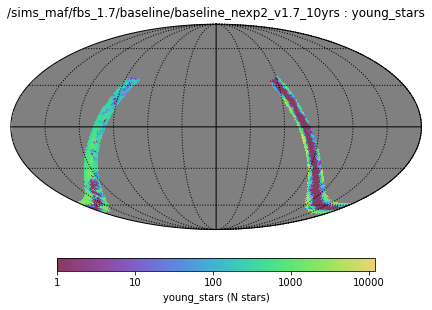

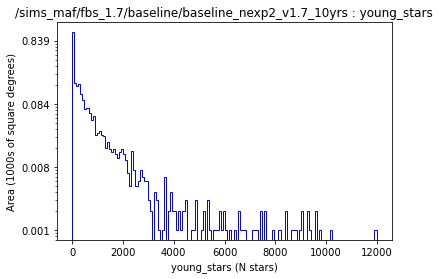

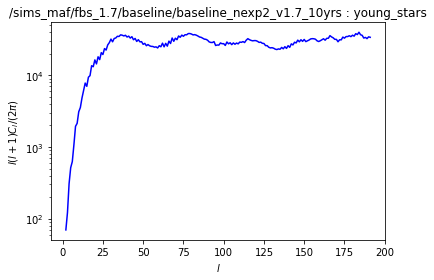

In [11]:
bd = metricBundles.makeBundlesDictFromList(bundleList)
bg = metricBundles.MetricBundleGroup(bd, conn, outDir=outDir, resultsDb=resultsDb)
bg.runAll()
bg.plotAll(closefigs=False)

In [12]:
for bl in bundleList:
    print(runName, bl.metric.name, bl.summaryValues)

/sims_maf/fbs_1.7/baseline/baseline_nexp2_v1.7_10yrs young_stars {'Sum': 1713370.823524624}


Querying database SummaryAllProps with no constraint for columns ['fieldRA', 'filter', 'fieldDec', 'fiveSigmaDepth'].
Found 2232598 visits
Running:  ['_sims_maf_fbs_1_5_footprints_footprint_big_skyv1_5_10yrs_young_stars_HEAL']


/data0/lsst_stack/stack/miniconda3-py38_4.9.2-0.4.2/Linux64/sims_maf/2.13.0.sims-93-g8bc2eb33+a14e41332a/python/lsst/sims/maf/maps/dustMap.py:24: UserWarning: Slicer value of nside (64) different from map value (128), using slicer value
  warnings.warn('Slicer value of nside (%i) different from map value (%i), using slicer value'


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.


/data0/lsst_stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.4.2/lib/python3.8/site-packages/healpy/projaxes.py:202: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  aximg = self.imshow(
/data0/lsst_stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.4.2/lib/python3.8/site-packages/healpy/pixelfunc.py:1581: UserWarning: monopole: 433.022  dipole: lon: 7.95996, lat: -50.509, amp: 1322.68
  warnings.warn(


Plotting complete.


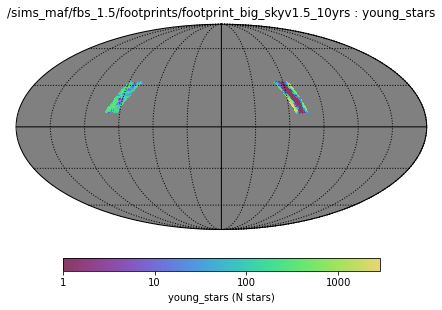

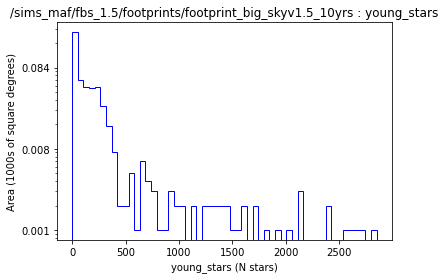

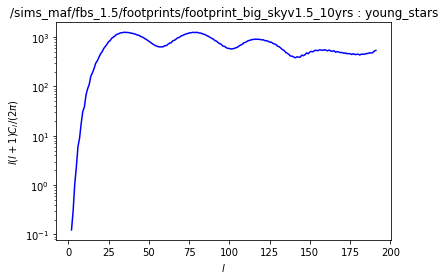

In [13]:
dbFile = '/sims_maf/fbs_1.5/footprints/footprint_big_skyv1.5_10yrs.db'
runName = dbFile.replace('.db', '')
conn = db.OpsimDatabase(dbFile)
outDir='temp'
resultsDb = db.ResultsDb(outDir=outDir)

bundleList = []
bundleList.append(metricBundles.MetricBundle(metric,slicer,sql, plotDict=plotDict,
                                             summaryMetrics=summaryStats,
                                             runName=runName))


bd = metricBundles.makeBundlesDictFromList(bundleList)
bg = metricBundles.MetricBundleGroup(bd, conn, outDir=outDir, resultsDb=resultsDb)
bg.runAll()
bg.plotAll(closefigs=False)

In [14]:
for bl in bundleList:
    print(runName, bl.metric.name, bl.summaryValues)

/sims_maf/fbs_1.5/footprints/footprint_big_skyv1.5_10yrs young_stars {'Sum': 138614.34080893372}


Querying database SummaryAllProps with no constraint for columns ['fieldRA', 'filter', 'fieldDec', 'fiveSigmaDepth'].
Found 2223753 visits
Running:  ['_sims_maf_fbs_1_5_footprints_footprint_gp_smoothv1_5_10yrs_young_stars_HEAL']


/data0/lsst_stack/stack/miniconda3-py38_4.9.2-0.4.2/Linux64/sims_maf/2.13.0.sims-93-g8bc2eb33+a14e41332a/python/lsst/sims/maf/maps/dustMap.py:24: UserWarning: Slicer value of nside (64) different from map value (128), using slicer value
  warnings.warn('Slicer value of nside (%i) different from map value (%i), using slicer value'


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.


/data0/lsst_stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.4.2/lib/python3.8/site-packages/healpy/projaxes.py:202: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  aximg = self.imshow(
/data0/lsst_stack/stack/miniconda3-py38_4.9.2-0.4.2/Linux64/sims_maf/2.13.0.sims-93-g8bc2eb33+a14e41332a/python/lsst/sims/maf/utils/mafUtils.py:106: UserWarning: Optimal bin calculation tried to make 262 bins, returning 200
  warnings.warn('Optimal bin calculation tried to make %.0f bins, returning %i'%(nbins, nbinMax))
/data0/lsst_stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.4.2/lib/python3.8/site-packages/healpy/pixelfunc.py:1581: UserWarning: monopole: 753.293  dipole: lon: 7.8924, lat: -31.1791, amp: 7979.76
  warnings.warn(


Plotting complete.


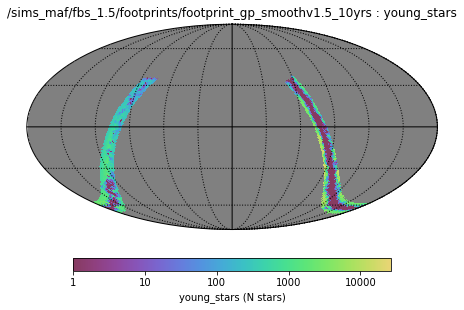

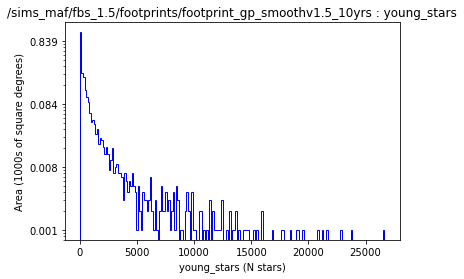

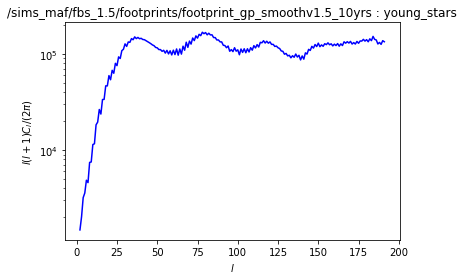

In [15]:
dbFile = '/sims_maf/fbs_1.5/footprints/footprint_gp_smoothv1.5_10yrs.db'
runName = dbFile.replace('.db', '')
conn = db.OpsimDatabase(dbFile)
outDir='temp'
resultsDb = db.ResultsDb(outDir=outDir)

bundleList = []
bundleList.append(metricBundles.MetricBundle(metric,slicer,sql, plotDict=plotDict,
                                             summaryMetrics=summaryStats,
                                             runName=runName))


bd = metricBundles.makeBundlesDictFromList(bundleList)
bg = metricBundles.MetricBundleGroup(bd, conn, outDir=outDir, resultsDb=resultsDb)
bg.runAll()
bg.plotAll(closefigs=False)

In [16]:
for bl in bundleList:
    print(runName, bl.metric.name, bl.summaryValues)

/sims_maf/fbs_1.5/footprints/footprint_gp_smoothv1.5_10yrs young_stars {'Sum': 2942425.502784976}


Querying database SummaryAllProps with no constraint for columns ['fieldRA', 'filter', 'fieldDec', 'fiveSigmaDepth'].
Found 2046219 visits
Running:  ['_sims_maf_fbs_1_7_footprint_tune_footprint_0_v1_710yrs_young_stars_HEAL']


/data0/lsst_stack/stack/miniconda3-py38_4.9.2-0.4.2/Linux64/sims_maf/2.13.0.sims-93-g8bc2eb33+a14e41332a/python/lsst/sims/maf/maps/dustMap.py:24: UserWarning: Slicer value of nside (64) different from map value (128), using slicer value
  warnings.warn('Slicer value of nside (%i) different from map value (%i), using slicer value'


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.


/data0/lsst_stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.4.2/lib/python3.8/site-packages/healpy/projaxes.py:202: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  aximg = self.imshow(
/data0/lsst_stack/stack/miniconda3-py38_4.9.2-0.4.2/Linux64/sims_maf/2.13.0.sims-93-g8bc2eb33+a14e41332a/python/lsst/sims/maf/utils/mafUtils.py:106: UserWarning: Optimal bin calculation tried to make 333 bins, returning 200
  warnings.warn('Optimal bin calculation tried to make %.0f bins, returning %i'%(nbins, nbinMax))
/data0/lsst_stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.4.2/lib/python3.8/site-packages/healpy/pixelfunc.py:1581: UserWarning: monopole: 536.247  dipole: lon: 8.34251, lat: -31.4754, amp: 5679.28
  warnings.warn(


Plotting complete.


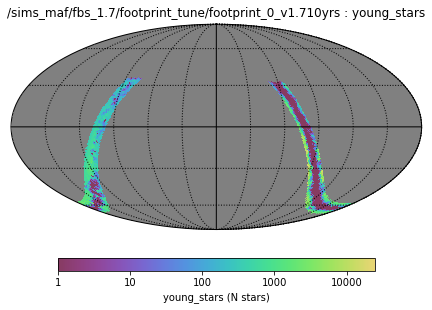

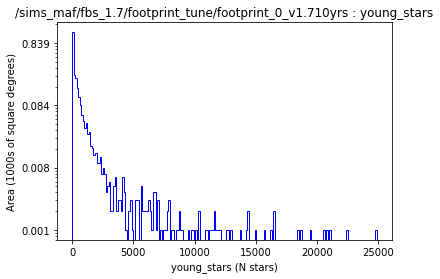

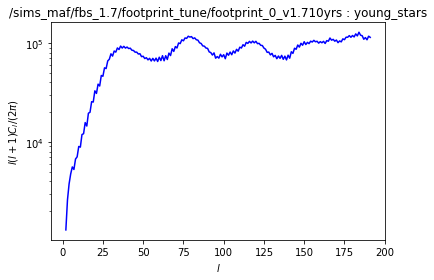

In [17]:
dbFile = '/sims_maf/fbs_1.7/footprint_tune/footprint_0_v1.710yrs.db'
runName = dbFile.replace('.db', '')
conn = db.OpsimDatabase(dbFile)
outDir='temp'
resultsDb = db.ResultsDb(outDir=outDir)

bundleList = []
bundleList.append(metricBundles.MetricBundle(metric,slicer,sql, plotDict=plotDict,
                                             summaryMetrics=summaryStats,
                                             runName=runName))


bd = metricBundles.makeBundlesDictFromList(bundleList)
bg = metricBundles.MetricBundleGroup(bd, conn, outDir=outDir, resultsDb=resultsDb)
bg.runAll()
bg.plotAll(closefigs=False)

In [18]:
for bl in bundleList:
    print(runName, bl.metric.name, bl.summaryValues)

/sims_maf/fbs_1.7/footprint_tune/footprint_0_v1.710yrs young_stars {'Sum': 2111617.583796965}
